In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## Building 2D model

In [3]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

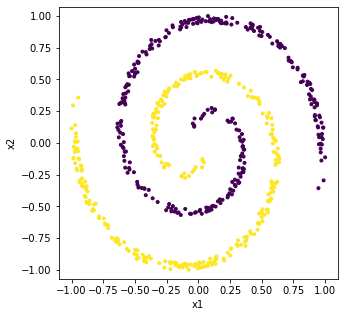

In [533]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [484]:
xx, yy = xx.to(device), yy.to(device)

## Distance Based Classification

In [6]:
# class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
#     def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
#         super().__init__(input_dim, num_centers, p=2)
        
#         nc = num_centers
#         if epsilon is not None:
#             nc += 1
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
#         self.epsilon = epsilon
        
#     def forward(self, x):
#         dists = super().forward(x)
        
#         if self.epsilon is not None:
#             dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
#         ### normalize similar to UMAP
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
#         ## scale the dists
# #         dists = torch.exp(-dists + self.scaler)
#         dists = 1-dists*torch.exp(self.scaler)
    
#         if self.bias is not None: dists = dists+self.bias
#         return dists

In [7]:
# class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
#     def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
#         super().__init__(input_dim, num_centers, p=2)
        
#         nc = num_centers
#         if epsilon is not None:
#             nc += 1
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
# #         self.scaler = nn.Parameter(torch.ones(1, 1)*1)

#         self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
#         self.epsilon = epsilon
        
#     def forward(self, x):
#         dists = super().forward(x)
        
#         if self.epsilon is not None:
#             dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
#         ### normalize similar to UMAP
# #         dists = dists/dists.std(dim=1, keepdim=True, unbiased=False)
# #         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True, unbiased=False))
# #         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True, unbiased=False)+1e-99) ## does not produce maxima at centers... (TEST by replacing this and below line) 
# #         dists = dists/(torch.norm(dists, dim=1, keepdim=True)+1e-99) ## does produce maxima at centers !! (scales to high dimensions ?)
# #         dists = dists/torch.norm(dists, dim=1, keepdim=True) ## does produce maxima at centers !! (scales to high dimensions ?)
        
#         ## scale the dists
# #         dists = torch.exp(-dists + self.scaler)
# #         dists = torch.exp(-dists)*self.scaler
#         dists = 1-dists*torch.exp(self.scaler)
# #         dists = 1-dists*self.scaler
# #         dists = 1-torch.log(dists*torch.exp(self.scaler) + 1)    
    
#         if self.bias is not None: dists = dists+self.bias
#         return dists

In [1102]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.scaler = nn.Parameter(torch.ones(1, 1)*1)

        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        dists = -dists/np.sqrt(dists.shape[1])
#         dists = torch.exp(dists) ### solves degenerate cases of centers != maxima

#         dists = dists/torch.norm(dists, p=2, dim=1, keepdim=True).data ## does produce maxima at centers !! (scales to high dimensions ?) (false when no exponential scale)
        ## ^^ This is similar to softmax if dists exponential and p=1 (i.e sum), 2 means something different.. Double Softmax ?!..
        dists = dists*torch.exp(self.scaler)
#         dists = dists*self.scaler

        if self.bias is not None: dists = dists+self.bias
        return dists

In [1103]:
# class DTeSM(DistanceTransform_Epsilon):
    
#     def __init__(self, input_dim, output_dim, epsilon=1.0):
#         super().__init__(input_dim, output_dim, bias=True, epsilon=epsilon)
        
#         self.scale_shift = dtnn.ScaleShift(-1, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
#         self.softmax = nn.Softmax(dim=-1)
#         self.temp_activ = None
        
#     def forward(self, x):
#         xo = super().forward(x)
#         xo = self.scale_shift(xo)
#         xo = self.softmax(xo)
#         self.temp_activ = xo.data
# #         return xo[:, :-1]
#         return xo

In [1104]:
class DT_epsilon_Classifier(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0):
        super().__init__(input_dim, output_dim, bias=True, epsilon=epsilon)
        
    def forward(self, x):
        xo = super().forward(x)
#         return xo[:, :-1]
        return F.softmax(xo, dim=-1)

In [1105]:
## reshape for multi-class classification (including epsilon)
yy = yy.reshape(-1).type(torch.LongTensor)

In [1106]:
model = DT_epsilon_Classifier(2, 2, epsilon=1.0)

In [1107]:
yout = model(xx)
yout.shape

torch.Size([600, 3])

In [1108]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

In [1109]:
def criterion(output, target):
    return F.nll_loss(torch.log(output), target)

Epoch: 99, Acc:0.68, Loss:0.9691351056098938
Epoch: 199, Acc:0.68, Loss:0.9037428498268127
Epoch: 299, Acc:0.67, Loss:0.8493891954421997
Epoch: 399, Acc:0.68, Loss:0.8054608702659607
Epoch: 499, Acc:0.68, Loss:0.7708296775817871
Epoch: 599, Acc:0.68, Loss:0.7436472177505493
Epoch: 699, Acc:0.69, Loss:0.7223526239395142
Epoch: 799, Acc:0.69, Loss:0.7052364945411682
Epoch: 899, Acc:0.70, Loss:0.6904420256614685
Epoch: 999, Acc:0.69, Loss:0.6776518821716309


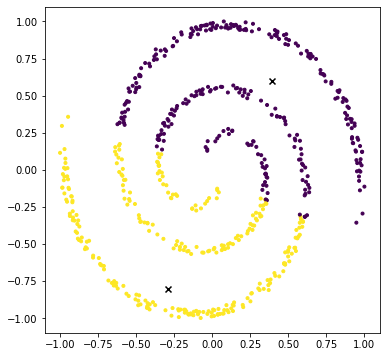

Epoch: 1099, Acc:0.70, Loss:0.6666734218597412
Epoch: 1199, Acc:0.70, Loss:0.6570010781288147
Epoch: 1299, Acc:0.70, Loss:0.6483548879623413
Epoch: 1399, Acc:0.70, Loss:0.6406068205833435
Epoch: 1499, Acc:0.70, Loss:0.6336719393730164
Epoch: 1599, Acc:0.70, Loss:0.6274702548980713
Epoch: 1699, Acc:0.70, Loss:0.6219261884689331
Epoch: 1799, Acc:0.70, Loss:0.6169907450675964
Epoch: 1899, Acc:0.70, Loss:0.6125635504722595
Epoch: 1999, Acc:0.70, Loss:0.6085759997367859


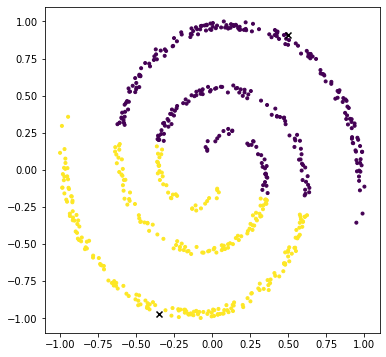

Epoch: 2099, Acc:0.70, Loss:0.6049690246582031
Epoch: 2199, Acc:0.70, Loss:0.6016945838928223
Epoch: 2299, Acc:0.70, Loss:0.5987071394920349
Epoch: 2399, Acc:0.70, Loss:0.5959685444831848
Epoch: 2499, Acc:0.70, Loss:0.5934498906135559
Epoch: 2599, Acc:0.70, Loss:0.5911242961883545
Epoch: 2699, Acc:0.70, Loss:0.5889707207679749
Epoch: 2799, Acc:0.70, Loss:0.5869717597961426
Epoch: 2899, Acc:0.70, Loss:0.5851108431816101
Epoch: 2999, Acc:0.70, Loss:0.5833758115768433


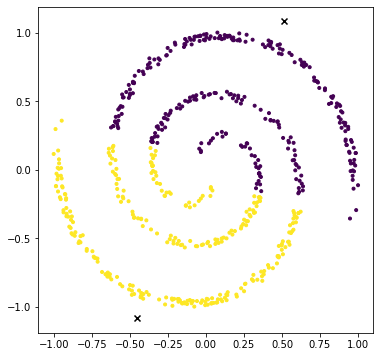

Epoch: 3099, Acc:0.70, Loss:0.5817540287971497
Epoch: 3199, Acc:0.70, Loss:0.5802362561225891
Epoch: 3299, Acc:0.70, Loss:0.5788126587867737
Epoch: 3399, Acc:0.70, Loss:0.5774756073951721
Epoch: 3499, Acc:0.70, Loss:0.5762176513671875
Epoch: 3599, Acc:0.70, Loss:0.575032651424408
Epoch: 3699, Acc:0.70, Loss:0.5739151239395142
Epoch: 3799, Acc:0.70, Loss:0.572860062122345
Epoch: 3899, Acc:0.70, Loss:0.5718621015548706
Epoch: 3999, Acc:0.70, Loss:0.5709178447723389


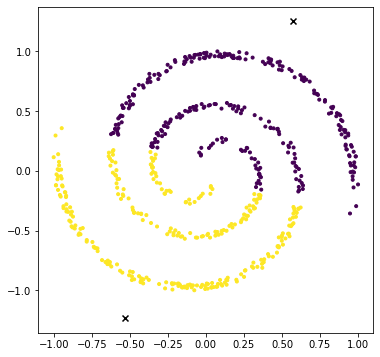

Epoch: 4099, Acc:0.70, Loss:0.5700231790542603
Epoch: 4199, Acc:0.70, Loss:0.5691738128662109
Epoch: 4299, Acc:0.70, Loss:0.5683678984642029
Epoch: 4399, Acc:0.70, Loss:0.5676019787788391
Epoch: 4499, Acc:0.70, Loss:0.5668738484382629
Epoch: 4599, Acc:0.70, Loss:0.566180944442749
Epoch: 4699, Acc:0.70, Loss:0.5655206441879272
Epoch: 4799, Acc:0.70, Loss:0.5648913383483887
Epoch: 4899, Acc:0.70, Loss:0.5642913579940796
Epoch: 4999, Acc:0.70, Loss:0.5637184977531433


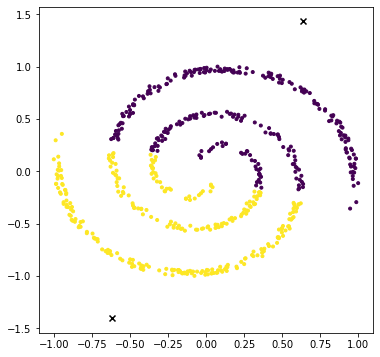

In [1110]:
%matplotlib inline

for epoch in range(5000):
# for epoch in range(1000):
    yout = model(xx)
    
#     yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     model.bias.data *= 0. ## Neglect the bias use

    if (epoch+1)%100 == 0:
        yout = model(xx)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [1111]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)
XX.shape

torch.Size([1000000, 2])

### Repeat below after changing parameters

In [1112]:
# YY = F.softmax(model(XX), dim=-1)
YY = model(XX)
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 3])

In [1113]:
yout = model(xx)
out = yout.max(dim=1)[1].data.cpu().numpy()

In [1114]:
max_actv = model(model.centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.96073854, 0.9578661 ], dtype=float32)

center: 0.96073854 max_grid: 0.9607259 True


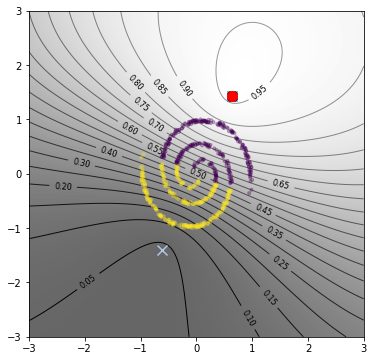

center: 0.9578661 max_grid: 0.95784277 True


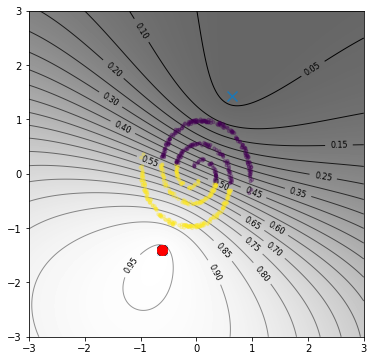

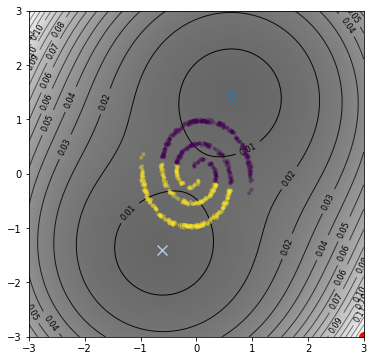

In [1115]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.centers.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [1116]:
model.bias.data, model.scaler, #torch.exp(model.scaler)

(tensor([[ 2.3265,  2.2882, -2.3121]]), Parameter containing:
 tensor([[0.5954]], requires_grad=True))

In [1117]:
"""
Updates:
1) Remove double exponential and double softmax in single neuron...

"""
print()

## Changing parameters

In [1118]:
# model.bias.data[0] = torch.Tensor([0, 0, -1])

In [1119]:
model.scaler.data[0,0] = 3.

### DTeSM Residual 

In [1120]:
class DTeSM(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0, itemp=10):
        ### NOTE: Here, not using bias leads to more uniform centroid activation, and easy to compare..
        super().__init__(input_dim, output_dim, bias=True, epsilon=epsilon)
        
        self.scale_shift = dtnn.ScaleShift(-1, scaler_init=itemp, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.temp_activ = None
        
    def forward(self, x):
        xo = super().forward(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_activ = xo.data
#         return xo[:, :-1]
        return xo

In [1121]:
class LocalResidual_DTeSM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, epsilon=None, itemp=1.0):
        super().__init__()
        self.layer0 = DTeSM(input_dim, hidden_dim, epsilon, itemp)
        if epsilon is not None:
            hidden_dim += 1
        self.layer1 = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        h = self.layer0(x)
        h = x + self.layer1(h)
        return h

In [1122]:
# model = LocalResidual_DTeSM(2, 5, epsilon=2.0, itemp=5.0)
# model(xx).shape

In [1123]:
# model.layer0.temp_activ

In [1124]:
model = nn.Sequential(
            LocalResidual_DTeSM(2, 10, epsilon=0.5, itemp=5.5),
            DT_epsilon_Classifier(2, 2, epsilon=0.5)
            )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [1125]:
yout = model(xx)
yout.shape

torch.Size([600, 3])

In [1126]:
model[0].layer1.weight.data[:, -1] = model[0].layer1.weight.data[:, -1]*0#-5.0

In [1051]:
# yy = yy.reshape(-1).type(torch.LongTensor)

In [1052]:
# def criterion(output, target):
#     return F.nll_loss(torch.log(output), target)

Epoch: 99, Acc:0.47, Loss:1.0865991115570068
Epoch: 199, Acc:0.62, Loss:1.0534694194793701
Epoch: 299, Acc:0.66, Loss:1.0224629640579224
Epoch: 399, Acc:0.68, Loss:0.9964984059333801
Epoch: 499, Acc:0.76, Loss:0.971479058265686
Epoch: 599, Acc:0.76, Loss:0.9366429448127747
Epoch: 699, Acc:0.82, Loss:0.9022804498672485
Epoch: 799, Acc:0.85, Loss:0.8566120266914368
Epoch: 899, Acc:0.87, Loss:0.8202831149101257
Epoch: 999, Acc:0.88, Loss:0.7888168096542358


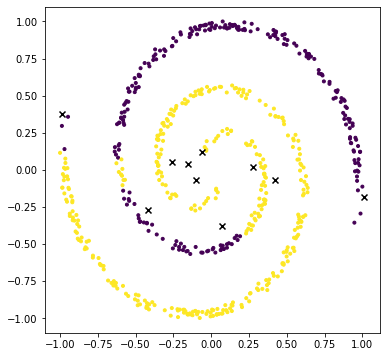

Epoch: 1099, Acc:0.90, Loss:0.7597867846488953
Epoch: 1199, Acc:0.90, Loss:0.7305685877799988
Epoch: 1299, Acc:0.92, Loss:0.707177996635437
Epoch: 1399, Acc:0.92, Loss:0.6898861527442932
Epoch: 1499, Acc:0.96, Loss:0.6480290293693542
Epoch: 1599, Acc:0.96, Loss:0.6345509886741638
Epoch: 1699, Acc:0.96, Loss:0.6253774762153625
Epoch: 1799, Acc:0.96, Loss:0.6180984973907471
Epoch: 1899, Acc:0.97, Loss:0.6094793081283569
Epoch: 1999, Acc:0.98, Loss:0.6002609729766846


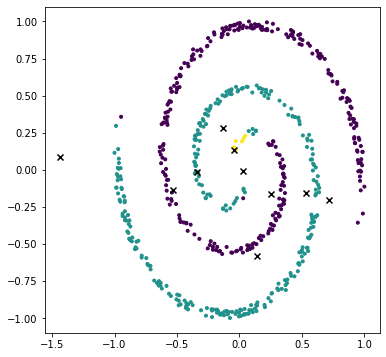

Epoch: 2099, Acc:0.98, Loss:0.592258870601654
Epoch: 2199, Acc:0.98, Loss:0.587682843208313
Epoch: 2299, Acc:0.98, Loss:0.5848836302757263
Epoch: 2399, Acc:0.98, Loss:0.5828913450241089
Epoch: 2499, Acc:0.98, Loss:0.581117570400238
Epoch: 2599, Acc:0.98, Loss:0.5795348882675171
Epoch: 2699, Acc:0.98, Loss:0.5781190991401672
Epoch: 2799, Acc:0.98, Loss:0.5771107077598572
Epoch: 2899, Acc:0.98, Loss:0.5761449933052063
Epoch: 2999, Acc:0.98, Loss:0.5752006769180298


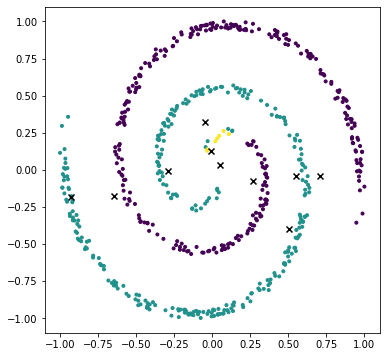

Epoch: 3099, Acc:0.98, Loss:0.5745737552642822
Epoch: 3199, Acc:0.98, Loss:0.5740733742713928
Epoch: 3299, Acc:0.98, Loss:0.5736643075942993
Epoch: 3399, Acc:0.98, Loss:0.573322594165802
Epoch: 3499, Acc:0.98, Loss:0.5730264186859131
Epoch: 3599, Acc:0.98, Loss:0.5727649331092834
Epoch: 3699, Acc:0.98, Loss:0.5725303888320923
Epoch: 3799, Acc:0.98, Loss:0.5723190903663635
Epoch: 3899, Acc:0.98, Loss:0.5721264481544495
Epoch: 3999, Acc:0.98, Loss:0.5719509124755859


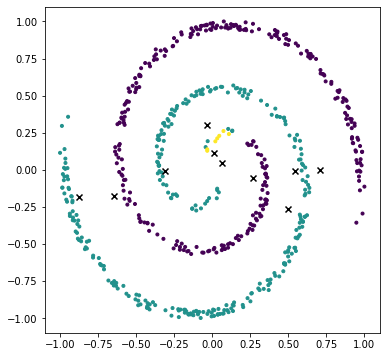

Epoch: 4099, Acc:0.98, Loss:0.5717902183532715
Epoch: 4199, Acc:0.98, Loss:0.5716426372528076
Epoch: 4299, Acc:0.98, Loss:0.571506679058075
Epoch: 4399, Acc:0.98, Loss:0.5713818669319153
Epoch: 4499, Acc:0.98, Loss:0.571266770362854
Epoch: 4599, Acc:0.98, Loss:0.571160078048706
Epoch: 4699, Acc:0.98, Loss:0.5710619688034058
Epoch: 4799, Acc:0.98, Loss:0.5709706544876099
Epoch: 4899, Acc:0.98, Loss:0.5708855986595154
Epoch: 4999, Acc:0.98, Loss:0.5708070993423462


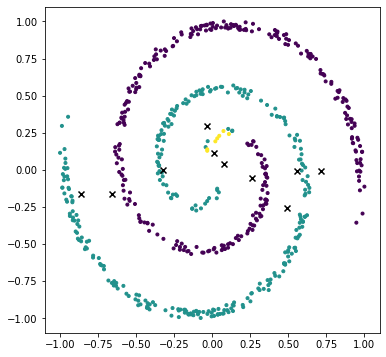

In [1053]:
%matplotlib inline

for epoch in range(5000):
    yout = model(xx)
    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     model.bias.data *= 0. ## Neglect the bias use
#     model[0].layer0.scaler.data = model[0].layer0.scaler.data*0+1.
    model[0].layer1.weight.data[:, -1] = model[0].layer1.weight.data[:, -1]*0

    if (epoch+1)%100 == 0:
        yout = model(xx)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model[0].layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [1054]:
model[0]

LocalResidual_DTeSM(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): Linear(in_features=11, out_features=2, bias=True)
)

In [1055]:
h1 = model[0](xx)
yout = model[1](h1)
out = yout.max(dim=1)[1].data.cpu().numpy()
## centroids and shift
c = model[0].layer0.centers.data.cpu()
d = model[0].layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

In [1056]:
max_actv = model[0].layer0(model[0].layer0.centers.data).data.cpu()
max_actv = max_actv.diag()#.numpy()
max_actv

tensor([0.9979, 0.9961, 0.9715, 0.9954, 0.9987, 0.9972, 0.9190, 0.6890, 0.2330,
        0.9999])

In [1057]:
# d[:10] = d[:10]*max_actv.unsqueeze(-1)

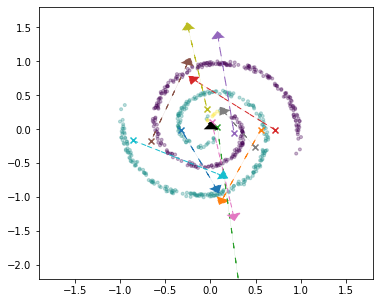

In [1058]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

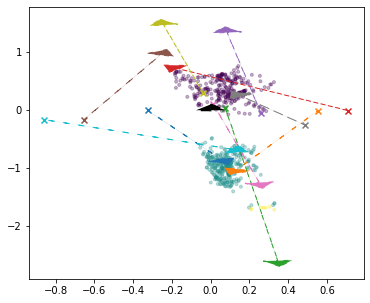

In [1059]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(h1.data[:,0], h1.data[:,1], c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
color = "k"
ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

### Visualize residual layer

In [1060]:
model[0](XX)
YY = model[0].layer0.temp_activ
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 11])

In [1061]:
# dir(model[0].layer0)
max_actv = max_actv.numpy()
max_actv

array([0.9979377 , 0.99607325, 0.97150743, 0.9953772 , 0.99871933,
       0.9972372 , 0.9190322 , 0.6890044 , 0.23296036, 0.99993944],
      dtype=float32)

center: 0.9979377 max_grid: 0.9978356 True


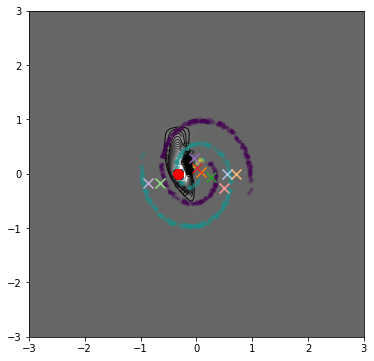

center: 0.99607325 max_grid: 0.9958753 True


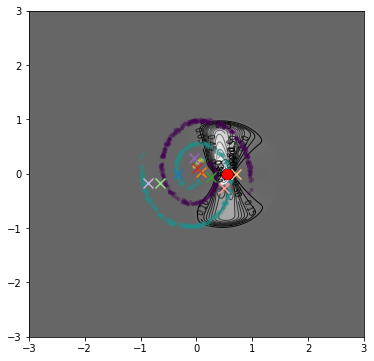

center: 0.97150743 max_grid: 0.96937424 True


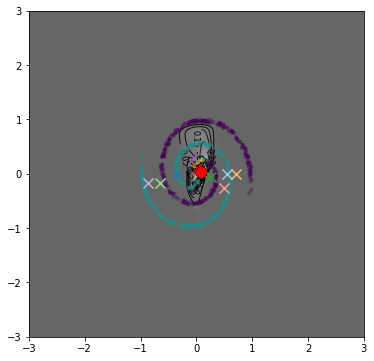

center: 0.9953772 max_grid: 0.9953041 True


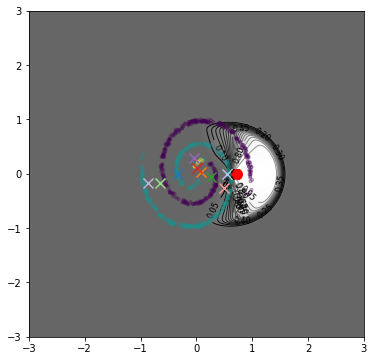

center: 0.99871933 max_grid: 0.9985825 True


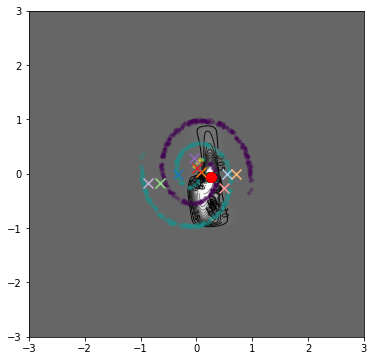

center: 0.9972372 max_grid: 0.99713624 True


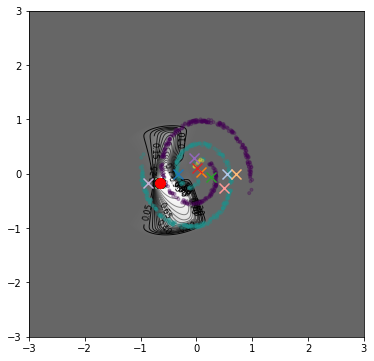

center: 0.9190322 max_grid: 0.9183474 True


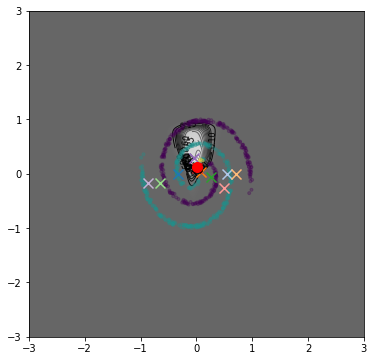

center: 0.6890044 max_grid: 0.68600327 True


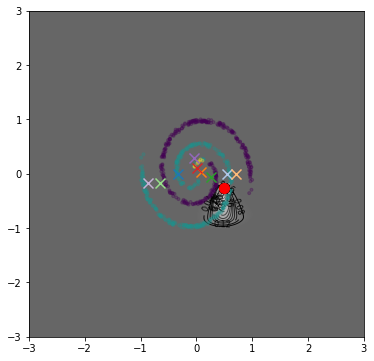

center: 0.23296036 max_grid: 0.23162693 True


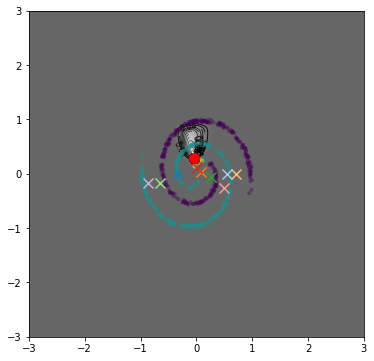

center: 0.99993944 max_grid: 0.9999378 True


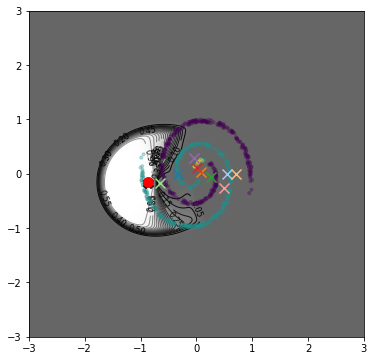

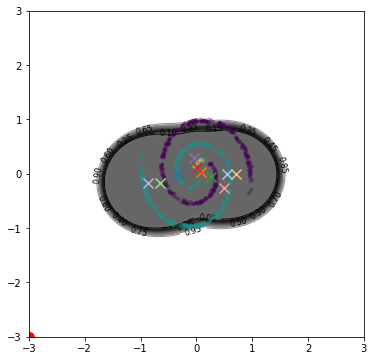

In [1062]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [672]:
model[0].layer0.scaler, torch.exp(model[0].layer0.scaler), model[0].layer0.bias

(Parameter containing:
 tensor([[1.8995]], requires_grad=True),
 tensor([[6.6828]], grad_fn=<ExpBackward>),
 Parameter containing:
 tensor([[ 0.9301,  0.4490, -0.4135,  1.7316, -0.1361,  0.8592, -1.2525, -0.1550,
           0.6612,  1.3129, -1.5483]], requires_grad=True))

### Visualize Classification Layer

In [673]:
# YY = F.softmax(model(XX), dim=-1)
YY = model[1](XX)
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 3])

In [674]:
max_actv = model[1](model[1].centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.9998354 , 0.99985313], dtype=float32)

In [675]:
c = model[1].centers.data.cpu()
h1 = model[0](xx)

center: 0.9998354 max_grid: 0.99983215 True


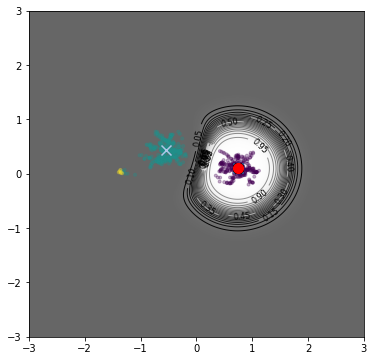

center: 0.99985313 max_grid: 0.99984884 True


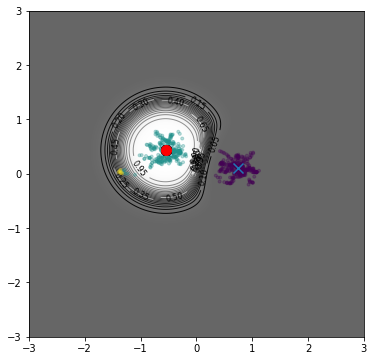

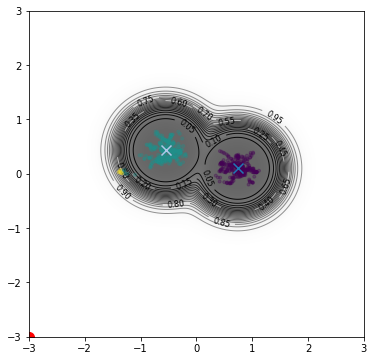

In [676]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(h1.data[:,0], h1.data[:,1], c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [677]:
model[1].scaler, model[1].bias

(Parameter containing:
 tensor([[2.3166]], requires_grad=True), Parameter containing:
 tensor([[ 1.7973,  1.9099, -1.8532]], requires_grad=True))

In [678]:
"""
Test various configurations if they prodice maxima==center by keeping two centers very close (the edge case..)
"""

'\nTest various configurations if they prodice maxima==center by keeping two centers very close (the edge case..)\n'

## GREEDY fit Residual Classifier with data based initialization

#### Train classifier layer first

In [679]:
model = DT_epsilon_Classifier(2, 2, epsilon=0.5)

In [680]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [681]:
def criterion(output, target):
    return F.nll_loss(torch.log(output), target)

Epoch: 99, Acc:0.31, Loss:1.098912239074707
Epoch: 199, Acc:0.60, Loss:1.0149747133255005
Epoch: 299, Acc:0.66, Loss:0.9519929885864258
Epoch: 399, Acc:0.68, Loss:0.9025126099586487
Epoch: 499, Acc:0.69, Loss:0.8623808026313782
Epoch: 599, Acc:0.69, Loss:0.8289948105812073
Epoch: 699, Acc:0.69, Loss:0.8006347417831421
Epoch: 799, Acc:0.69, Loss:0.7759727835655212
Epoch: 899, Acc:0.69, Loss:0.7537548542022705
Epoch: 999, Acc:0.69, Loss:0.7338269948959351


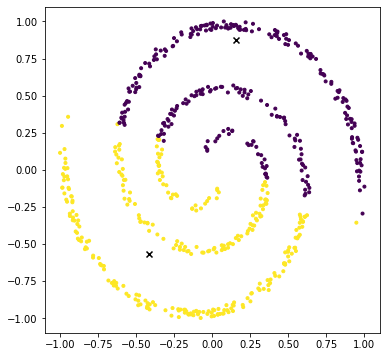

Epoch: 1099, Acc:0.69, Loss:0.7164117693901062
Epoch: 1199, Acc:0.70, Loss:0.7013158202171326
Epoch: 1299, Acc:0.70, Loss:0.6881940960884094
Epoch: 1399, Acc:0.70, Loss:0.6767156720161438
Epoch: 1499, Acc:0.70, Loss:0.6666138768196106
Epoch: 1599, Acc:0.70, Loss:0.6576566696166992
Epoch: 1699, Acc:0.70, Loss:0.6496874094009399
Epoch: 1799, Acc:0.70, Loss:0.6425817012786865
Epoch: 1899, Acc:0.70, Loss:0.6362109184265137
Epoch: 1999, Acc:0.70, Loss:0.6304784417152405


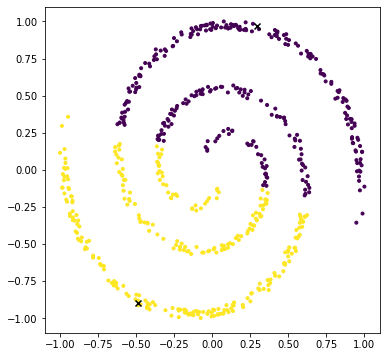

Epoch: 2099, Acc:0.70, Loss:0.6252951622009277
Epoch: 2199, Acc:0.70, Loss:0.6206009984016418
Epoch: 2299, Acc:0.70, Loss:0.6163240075111389
Epoch: 2399, Acc:0.70, Loss:0.6124129891395569
Epoch: 2499, Acc:0.70, Loss:0.6088278293609619
Epoch: 2599, Acc:0.70, Loss:0.6055313348770142
Epoch: 2699, Acc:0.70, Loss:0.6024934649467468
Epoch: 2799, Acc:0.70, Loss:0.5996865630149841
Epoch: 2899, Acc:0.70, Loss:0.5970861911773682
Epoch: 2999, Acc:0.70, Loss:0.5946719646453857


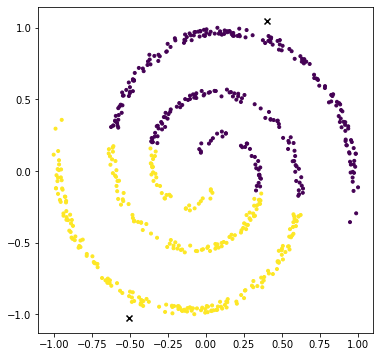

Epoch: 3099, Acc:0.70, Loss:0.5924245119094849
Epoch: 3199, Acc:0.70, Loss:0.5903289914131165
Epoch: 3299, Acc:0.70, Loss:0.5883705615997314
Epoch: 3399, Acc:0.70, Loss:0.5865365862846375
Epoch: 3499, Acc:0.70, Loss:0.584817111492157
Epoch: 3599, Acc:0.70, Loss:0.5832021832466125
Epoch: 3699, Acc:0.70, Loss:0.5816827416419983
Epoch: 3799, Acc:0.70, Loss:0.5802521109580994
Epoch: 3899, Acc:0.70, Loss:0.5789020657539368
Epoch: 3999, Acc:0.70, Loss:0.5776280164718628


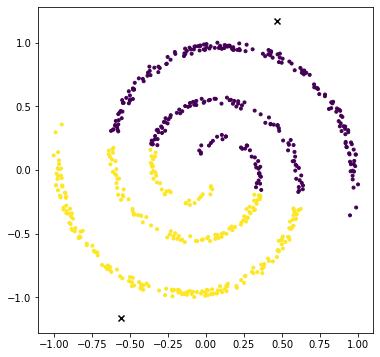

Epoch: 4099, Acc:0.70, Loss:0.5764231085777283
Epoch: 4199, Acc:0.70, Loss:0.5752825140953064
Epoch: 4299, Acc:0.70, Loss:0.5742018222808838
Epoch: 4399, Acc:0.70, Loss:0.5731775760650635
Epoch: 4499, Acc:0.70, Loss:0.5722046494483948
Epoch: 4599, Acc:0.70, Loss:0.5712808966636658
Epoch: 4699, Acc:0.70, Loss:0.5704017877578735
Epoch: 4799, Acc:0.70, Loss:0.5695657134056091
Epoch: 4899, Acc:0.70, Loss:0.568769097328186
Epoch: 4999, Acc:0.70, Loss:0.5680102109909058


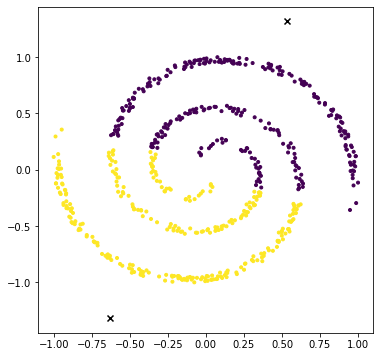

In [682]:
%matplotlib inline

for epoch in range(5000):
    yout = model(xx)
#     yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%100 == 0:
        yout = model(xx)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [683]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)
XX.shape

torch.Size([1000000, 2])

In [684]:
# YY = F.softmax(model(XX), dim=-1)
YY = model(XX)
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 3])

In [685]:
yout = model(xx)
out = yout.max(dim=1)[1].data.cpu().numpy()

In [686]:
max_actv = model(model.centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.9425614 , 0.94645023], dtype=float32)

center: 0.9425614 max_grid: 0.9425558 True


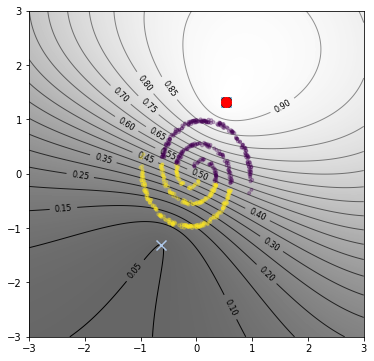

center: 0.94645023 max_grid: 0.9464027 True


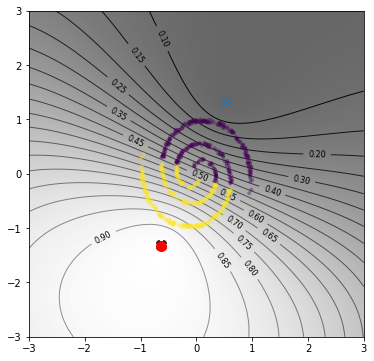

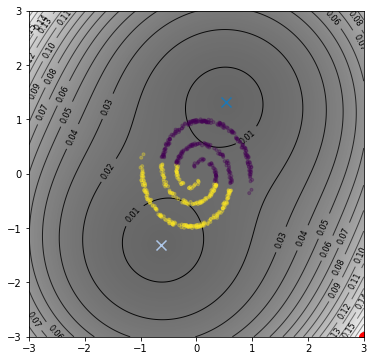

In [687]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.centers.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [688]:
model.bias.data, torch.exp(model.scaler)

(tensor([[ 2.3325,  2.3715, -2.3517]]),
 tensor([[1.0188]], grad_fn=<ExpBackward>))

In [689]:
model(model.centers.data).argmax(dim=1)

tensor([0, 1])

In [690]:
classifier = model

#### Train Residual with centers as target

In [742]:
classifier.centers.data[[0,0,1,1]]

tensor([[ 0.5319,  1.3175],
        [ 0.5319,  1.3175],
        [-0.6290, -1.3164],
        [-0.6290, -1.3164]])

In [883]:
model = LocalResidual_DTeSM(2, 5, epsilon=0.5, itemp=5.0)

In [884]:
idx = torch.randperm(len(xx))[:model.layer0.centers.shape[0]]
model.layer0.centers.data = xx[idx]

In [885]:
# classifier.centers.data[yy[idx]]

## Residual like difference
diff = classifier.centers.data[yy[idx]] - model.layer0.centers.data
model.layer1.weight.data[:, :model.layer0.centers.shape[0]] = diff.t()

In [886]:
# model.layer1.weight.data *= 0.

In [887]:
# model.layer0.scaler.data[0,0] = 2.

In [888]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [889]:
yout = model(xx)
yout.shape

torch.Size([600, 2])

In [890]:
model.layer1.weight.data[:, -1] = model.layer1.weight.data[:, -1]*0 ## for epsilon

In [891]:
_yy = classifier.centers.data[yy]
_yy.shape

torch.Size([600, 2])

Epoch: 99, Acc:0.63, Loss:0.8781645894050598
Epoch: 199, Acc:0.64, Loss:0.8327434062957764
Epoch: 299, Acc:0.66, Loss:0.7997996807098389
Epoch: 399, Acc:0.71, Loss:0.7633991837501526
Epoch: 499, Acc:0.72, Loss:0.7316602468490601
Epoch: 599, Acc:0.73, Loss:0.6974722146987915
Epoch: 699, Acc:0.75, Loss:0.6565236449241638
Epoch: 799, Acc:0.76, Loss:0.6161860823631287
Epoch: 899, Acc:0.78, Loss:0.5879175662994385
Epoch: 999, Acc:0.80, Loss:0.5684235095977783


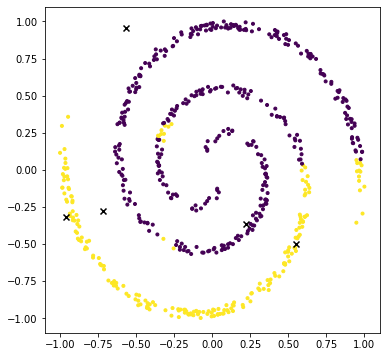

Epoch: 1099, Acc:0.81, Loss:0.5533345341682434
Epoch: 1199, Acc:0.82, Loss:0.5402746796607971
Epoch: 1299, Acc:0.82, Loss:0.5284976959228516
Epoch: 1399, Acc:0.83, Loss:0.5179556012153625
Epoch: 1499, Acc:0.83, Loss:0.5087007880210876
Epoch: 1599, Acc:0.84, Loss:0.5007461309432983
Epoch: 1699, Acc:0.84, Loss:0.4940122365951538
Epoch: 1799, Acc:0.85, Loss:0.488393098115921
Epoch: 1899, Acc:0.85, Loss:0.48376601934432983
Epoch: 1999, Acc:0.85, Loss:0.4799916446208954


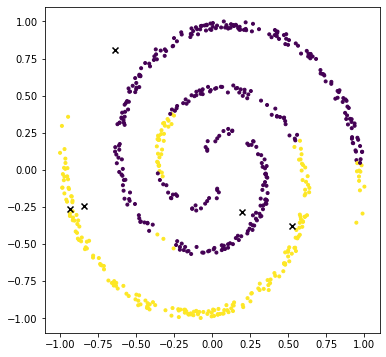

Epoch: 2099, Acc:0.86, Loss:0.47692185640335083
Epoch: 2199, Acc:0.86, Loss:0.47440969944000244
Epoch: 2299, Acc:0.86, Loss:0.47231701016426086
Epoch: 2399, Acc:0.86, Loss:0.47052037715911865
Epoch: 2499, Acc:0.86, Loss:0.46892261505126953
Epoch: 2599, Acc:0.87, Loss:0.46746495366096497
Epoch: 2699, Acc:0.87, Loss:0.466114342212677
Epoch: 2799, Acc:0.87, Loss:0.4648393392562866
Epoch: 2899, Acc:0.87, Loss:0.463614821434021
Epoch: 2999, Acc:0.87, Loss:0.4624275267124176


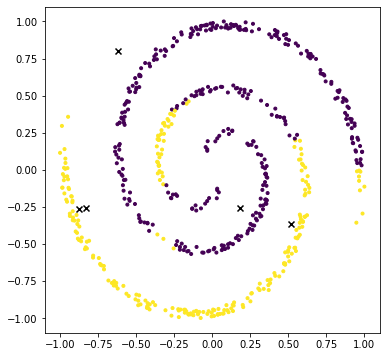

Epoch: 3099, Acc:0.87, Loss:0.46128153800964355
Epoch: 3199, Acc:0.87, Loss:0.46018823981285095
Epoch: 3299, Acc:0.88, Loss:0.45915770530700684
Epoch: 3399, Acc:0.88, Loss:0.4581989049911499
Epoch: 3499, Acc:0.88, Loss:0.45730483531951904
Epoch: 3599, Acc:0.88, Loss:0.4564771056175232
Epoch: 3699, Acc:0.88, Loss:0.45572373270988464
Epoch: 3799, Acc:0.88, Loss:0.4549888074398041
Epoch: 3899, Acc:0.88, Loss:0.45432958006858826
Epoch: 3999, Acc:0.88, Loss:0.4537041187286377


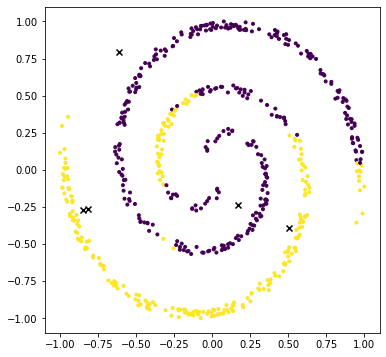

Epoch: 4099, Acc:0.88, Loss:0.45312735438346863
Epoch: 4199, Acc:0.88, Loss:0.45258545875549316
Epoch: 4299, Acc:0.88, Loss:0.45207449793815613
Epoch: 4399, Acc:0.88, Loss:0.4515926241874695
Epoch: 4499, Acc:0.88, Loss:0.4511209726333618
Epoch: 4599, Acc:0.88, Loss:0.4506674110889435
Epoch: 4699, Acc:0.88, Loss:0.450234591960907
Epoch: 4799, Acc:0.88, Loss:0.44978007674217224
Epoch: 4899, Acc:0.88, Loss:0.4493369460105896
Epoch: 4999, Acc:0.88, Loss:0.448883980512619


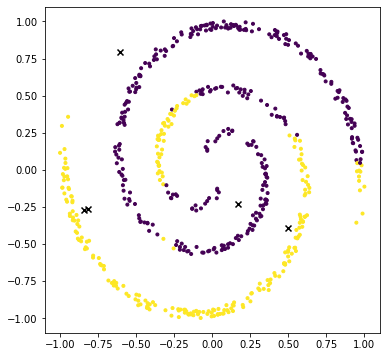

In [892]:
%matplotlib inline

for epoch in range(5000):
    yout = model(xx)
    
    loss = criterion(yout, _yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.layer0.bias.data *= 0. ## Neglect the bias use
#     model[0].layer0.scaler.data = model[0].layer0.scaler.data*0+1.
    model.layer1.weight.data[:, -1] = model.layer1.weight.data[:, -1]*0

    if (epoch+1)%100 == 0:
        yout_ = classifier(model(xx))
        accuracy = (yout_.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout_.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [893]:
model

LocalResidual_DTeSM(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): Linear(in_features=6, out_features=2, bias=True)
)

In [894]:
h1 = model(xx)
yout = classifier(h1)
out = yout.max(dim=1)[1].data.cpu().numpy()
## centroids and shift
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

In [895]:
max_actv = model.layer0(model.layer0.centers.data).data.cpu()
max_actv = max_actv.diag()#.numpy()
max_actv

tensor([1.0000, 1.0000, 0.9647, 0.9647, 1.0000])

In [896]:
# d[:10] = d[:10]*max_actv.unsqueeze(-1)

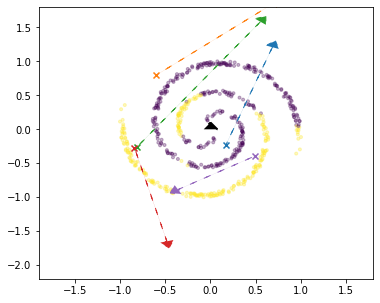

In [897]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

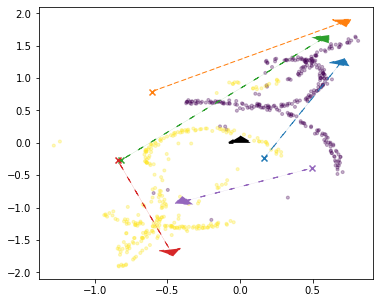

In [898]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(h1.data[:,0], h1.data[:,1], c=yy, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
color = "k"
ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

### Visualize residual layer

In [899]:
model(XX)
YY = model.layer0.temp_activ
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 6])

In [900]:
# dir(model[0].layer0)
max_actv = max_actv.numpy()
max_actv

array([1.       , 1.       , 0.9646592, 0.9646592, 1.       ],
      dtype=float32)

center: 1.0 max_grid: 1.0 True


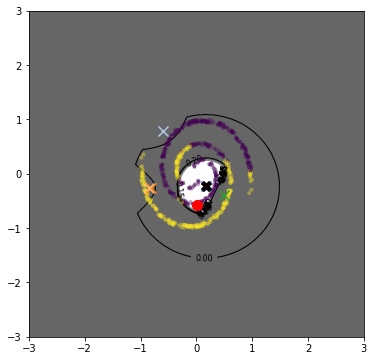

center: 1.0 max_grid: 1.0 True


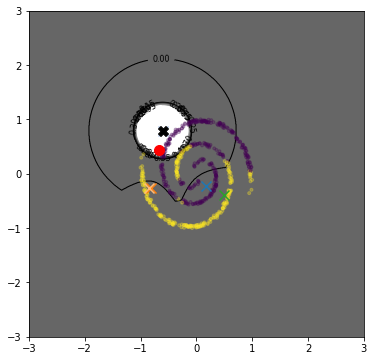

center: 0.9646592 max_grid: 0.9646707 False


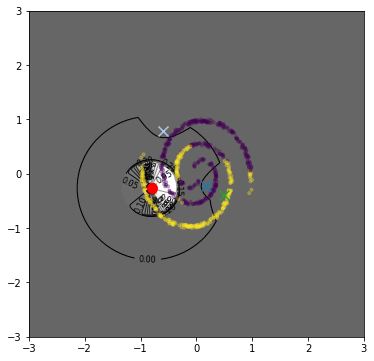

center: 0.9646592 max_grid: 0.96466 False


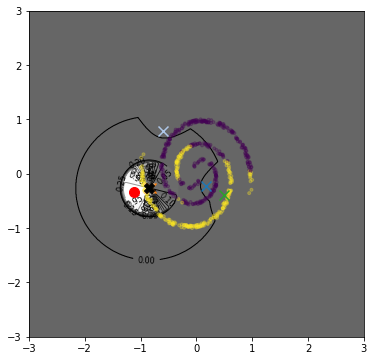

center: 1.0 max_grid: 1.0 True


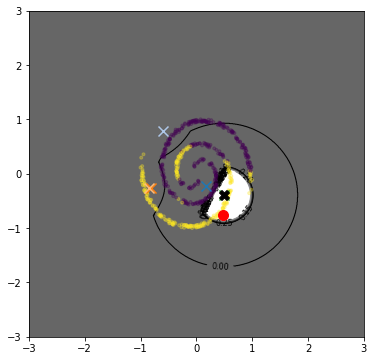

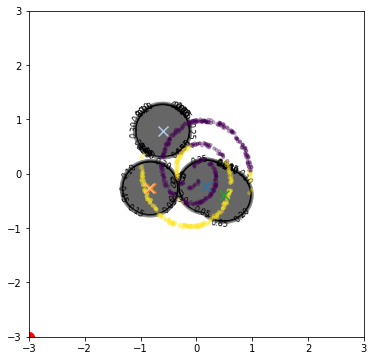

In [901]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [902]:
model.layer0.scaler, torch.exp(model.layer0.scaler), model.layer0.bias

(Parameter containing:
 tensor([[3.2368]], requires_grad=True),
 tensor([[25.4522]], grad_fn=<ExpBackward>),
 Parameter containing:
 tensor([[0., 0., -0., 0., -0., -0.]], requires_grad=True))

In [903]:
# model.layer0.epsilon = 0.5

In [904]:
# model.layer0.scaler.data[0,0] = 2.0

## Extract information from data and gradient

In [905]:
"""
Extract gradient information... The gradient will provide with target for newly added residual network..
"""

'\nExtract gradient information... The gradient will provide with target for newly added residual network..\n'

In [906]:
h1_grad = None
def hidden_gradient(grad):
    global h1_grad
    h1_grad = grad
    return grad

In [907]:
criterion = nn.NLLLoss()

In [908]:
## Get points with errors 
model.zero_grad()
xx_ = torch.autograd.Variable(xx.clone(), requires_grad=True)
h1 = model(xx_)
h1.register_hook(hidden_gradient)
yout = classifier(h1)
criterion(yout, yy).backward()

out = yout.max(dim=1)[1].data.cpu().numpy()
errs = F.nll_loss(yout.data, yy, reduction="none")
idx_err = torch.topk(errs, k=10)[1]

In [909]:
h1_grad.shape

torch.Size([600, 2])

In [910]:
h1 = h1.data

In [911]:
xx_.grad.shape

torch.Size([600, 2])

In [912]:
# model.layer1.weight.grad.shape

In [913]:
t = 0
idx = idx_err[t]

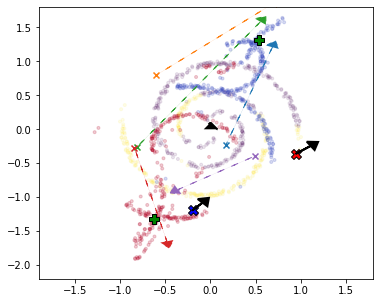

In [914]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.1)

c2 = classifier.centers.data.cpu()
ax.scatter(c2[:,0], c2[:,1], fc="g", ec="k", marker= 'P', s=100, zorder=100)

ax.scatter(h1.data[:,0], h1.data[:,1], c=yy, marker= '.', alpha=0.2, cmap="coolwarm")

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)

plt.scatter(h1[idx,0], h1[idx,1], s=100, color='blue', marker="X", ec="k")
g = -h1_grad[idx]*len(xx)
ax.arrow(h1[idx,0], h1[idx,1], g[0], g[1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle="solid", linewidth=2.0)

plt.scatter(xx[idx,0], xx[idx,1], s=100, color='red', marker="X", ec="k")
g = -xx_.grad[idx]*len(xx)
ax.arrow(xx[idx,0], xx[idx,1], g[0], g[1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle="solid", linewidth=2.0)

plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

In [915]:
xx[idx], yy[idx]

(tensor([ 0.9472, -0.3571]), tensor(0))

In [916]:
h1[idx], h1_grad[idx]*len(xx)

(tensor([-0.1963, -1.1891]), tensor([-0.1084, -0.1093]))

In [917]:
xx_.grad[idx]*len(xx)

tensor([-0.1600, -0.1131])

In [918]:
## Gradient descent to find exact target

In [919]:
h1_ = torch.autograd.Variable(h1.clone(), requires_grad=True)
optimizer = torch.optim.Adam([h1_], lr=0.03)

In [920]:
model.zero_grad()

In [921]:
for i in range(50):
    optimizer.zero_grad()
    yout = classifier(h1_)
    criterion(yout, yy).backward()
    optimizer.step()

In [922]:
h1_[idx], h1[idx]

(tensor([1.2289, 0.4592], grad_fn=<SelectBackward>),
 tensor([-0.1963, -1.1891]))

In [923]:
yout[idx], yy[idx]

(tensor([0.7923, 0.1939, 0.0138], grad_fn=<SelectBackward>), tensor(0))

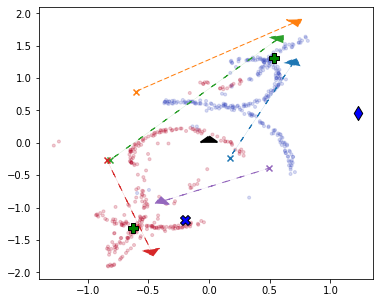

In [924]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(h1.data[:,0], h1.data[:,1], c=yy, marker= '.', alpha=0.2, cmap="coolwarm")

c2 = classifier.centers.data.cpu()
ax.scatter(c2[:,0], c2[:,1], fc="g", ec="k", marker= 'P', s=100, zorder=100)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)

plt.scatter(h1[idx,0], h1[idx,1], s=100, color='blue', marker="X", ec="k")
plt.scatter(h1_.data[idx,0], h1_.data[idx,1], s=100, color='blue', marker="d", ec="k", zorder=100)

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

In [925]:
model.layer1.bias

Parameter containing:
tensor([-0.2927, -0.3377], requires_grad=True)

In [926]:
for n, p in model.named_parameters():
    print(f"{n}\t{p.data.shape}")

layer0.centers	torch.Size([5, 2])
layer0.scaler	torch.Size([1, 1])
layer0.bias	torch.Size([1, 6])
layer1.weight	torch.Size([2, 6])
layer1.bias	torch.Size([2])


In [927]:
shiftby = h1_.data[idx]-xx[idx]-model.layer1.bias.data ## this is required shift vector

In [928]:
# model.layer0.bias

In [929]:
_c = torch.cat((model.layer0.centers.data, xx[idx:idx+1]), dim=0)
model.layer0.centers.data = _c

_v = torch.cat((model.layer1.weight.data[:,:-1], 
                shiftby.unsqueeze(dim=0).t(), 
                model.layer1.weight.data[:,-1:]), dim=1)
model.layer1.weight.data = _v

if model.layer0.bias is not None:
    _s = torch.cat([model.layer0.bias.data[:,:-1], 
                    torch.ones(1, 1)*0, 
                    model.layer0.bias.data[:,-1:]], dim=1)
    model.layer0.bias.data = _s

In [930]:
model.layer0.bias.data[:,-2] = -0.0

### Visualize Neuron Addition

In [931]:
h1 = model(xx)
yout = classifier(h1)
out = yout.max(dim=1)[1].data.cpu().numpy()
## centroids and shift
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

In [932]:
accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
accuracy

tensor(0.9017)

In [933]:
max_actv = model.layer0(model.layer0.centers.data).data.cpu()
max_actv = max_actv.diag()#.numpy()
max_actv

tensor([1.0000, 1.0000, 0.9647, 0.9647, 1.0000, 1.0000])

In [934]:
# d[:10] = d[:10]*max_actv.unsqueeze(-1)

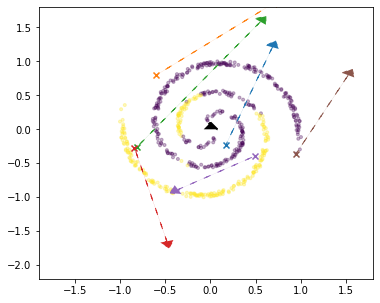

In [935]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

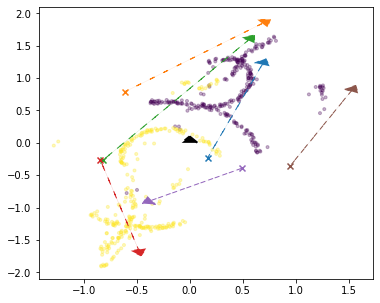

In [936]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(h1.data[:,0], h1.data[:,1], c=yy, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
color = "k"
ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

### Visualize residual layer

In [937]:
model(XX)
YY = model.layer0.temp_activ
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 7])

In [938]:
# dir(model[0].layer0)
max_actv = max_actv.numpy()
max_actv

array([1.       , 1.       , 0.9646592, 0.9646592, 1.       , 1.       ],
      dtype=float32)

center: 1.0 max_grid: 1.0 True


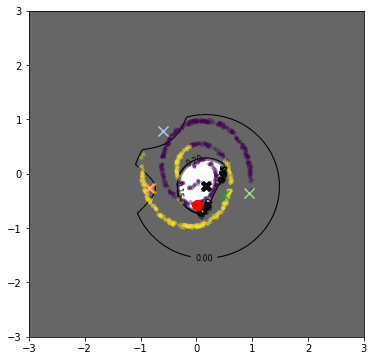

center: 1.0 max_grid: 1.0 True


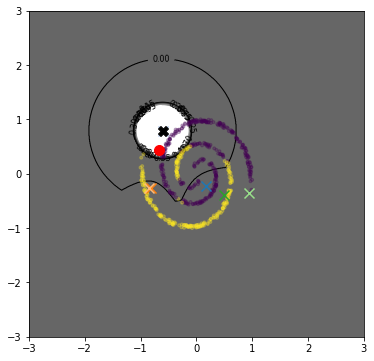

center: 0.9646592 max_grid: 0.9646707 False


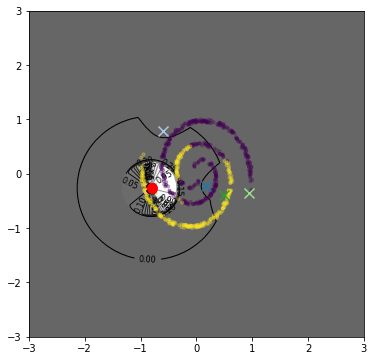

center: 0.9646592 max_grid: 0.96466 False


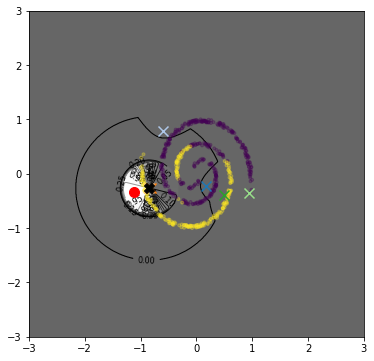

center: 1.0 max_grid: 1.0 True


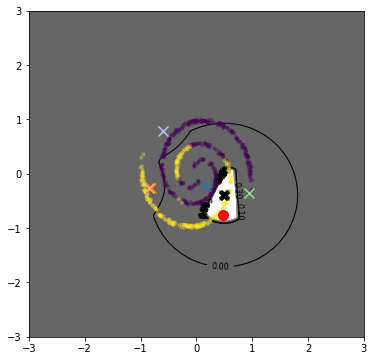

center: 1.0 max_grid: 1.0 True


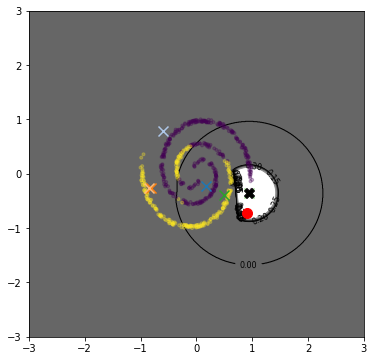

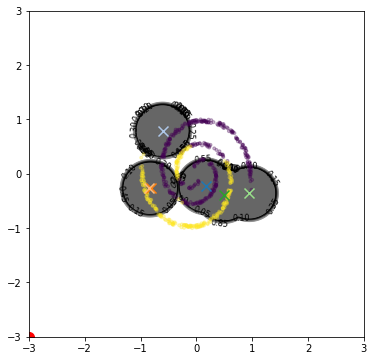

In [939]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [1131]:
model[0].layer0.scaler, torch.exp(model[0].layer0.scaler), model[0].layer0.bias

(Parameter containing:
 tensor([[0.]], requires_grad=True),
 tensor([[1.]], grad_fn=<ExpBackward>),
 Parameter containing:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True))

In [651]:
# model.layer0.epsilon = 0.5

In [652]:
# model.layer0.scaler.data[0,0] = 2.0

In [1130]:
model

Sequential(
  (0): LocalResidual_DTeSM(
    (layer0): DTeSM(
      (scale_shift): ScaleShift()
      (softmax): Softmax(dim=-1)
    )
    (layer1): Linear(in_features=11, out_features=2, bias=True)
  )
  (1): DT_epsilon_Classifier()
)